# Explore embedding space of CLAY Encoder for different sensors

In [1]:
import sys
import warnings

sys.path.append("..")
warnings.filterwarnings(action="ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange

from src.datamodule import ClayDataModule
from src.model import ClayMAEModule

In [3]:
DATA_DIR = "/home/ubuntu/data"
CHECKPOINT_PATH = "../checkpoints/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
METADATA_PATH = "../configs/metadata.yaml"
CHIP_SIZE = 224
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### MODEL

Load the model with best checkpoint path and set it in eval mode.

In [4]:
# As we want to visualize the embeddings from the model, we neither mask the input image or shuffle the patches
module = ClayMAEModule.load_from_checkpoint(checkpoint_path=CHECKPOINT_PATH,
                                           metadata_path=METADATA_PATH,
                                           mask_ratio=0., 
                                           shuffle=False)

module.eval();

### DATAMODULE

Load the ClayDataModule

In [14]:
# For model training, we stack chips from one sensor into batches of size 128. 
# This reduces the num_workers we need to load the batches & speeds up the training process.
# Here, although the batch size is 1, the data module reads batch of size 128.
dm = ClayDataModule(
    data_dir=DATA_DIR,
    metadata_path=METADATA_PATH,
    size=CHIP_SIZE,
    batch_size=1,
    num_workers=1
)
dm.setup(stage="fit")

Total number of chips: 193


Let us look at the data directory.

We have a folder for each sensor, i.e:
- Landsat l1
- Landsat l2
- Sentinel 1 rtc
- Sentinel 2 l2a
- Naip
- Linz

And, under each folder, we have stacks of chips as `.npz` files.

In [15]:
!tree -L 1 {DATA_DIR}

/home/ubuntu/data
├── landsat-c2l1
├── landsat-c2l2-sr
├── linz
├── naip
├── sentinel-1-rtc
└── sentinel-2-l2a

6 directories, 0 files


In [16]:
!tree -L 2 {DATA_DIR}/naip | head -5

/home/ubuntu/data/naip
├── cube_10.npz
├── cube_100045.npz
├── cube_100046.npz
├── cube_100072.npz


Now, lets look at what we have in each of the `.npz` files.

In [17]:
sample = np.load("/home/ubuntu/data/naip/cube_10.npz")

In [18]:
sample.keys()

KeysView(NpzFile '/home/ubuntu/data/naip/cube_10.npz' with keys: pixels, lon_norm, lat_norm, week_norm, hour_norm)

In [19]:
sample["pixels"].shape

(128, 4, 256, 256)

In [20]:
sample["lat_norm"].shape, sample["lon_norm"].shape

((128, 2), (128, 2))

In [21]:
sample["week_norm"].shape, sample["hour_norm"].shape

((128, 2), (128, 2))

As we see above, chips are stacked in batches of size `128`.  
The sample we are looking at is from `NAIP` so it has 4 bands & of size `256 x 256`.  
We also get normalized lat/lon & timestep (hour/week) information that is *(optionally required) by the model. If you don't have this handy, feel free to pass zero tensors in their place.

Load a batch of data from ClayDataModule

ClayDataModule is designed to fetch random batches of data from different sensors sequentially, i.e batches are in ascending order of their directory - Landsat 1, Landsat 2, LINZ, NAIP, Sentinel 1 rtc, Sentinel 2 L2A and it repeats after that. 

In [25]:
# We have a random sample subset of the data, so it's okay to use either the train or val dataloader
dl = iter(dm.train_dataloader())

In [26]:
l1 = next(dl)
l2 = next(dl)
linz = next(dl)
naip = next(dl)
s1 = next(dl)
s2 = next(dl)

In [27]:
for sensor, chips in zip(("l1", "l2", "linz", "naip", "s1", "s2"), (l1, l2, linz, naip, s1, s2)):
    print(f"{chips['platform'][0]:<15}", chips["pixels"].shape, chips["time"].shape, chips["latlon"].shape)

landsat-c2l1    torch.Size([128, 6, 224, 224]) torch.Size([128, 4]) torch.Size([128, 4])
landsat-c2l2-sr torch.Size([128, 6, 224, 224]) torch.Size([128, 4]) torch.Size([128, 4])
linz            torch.Size([128, 3, 224, 224]) torch.Size([128, 4]) torch.Size([128, 4])
naip            torch.Size([128, 4, 224, 224]) torch.Size([128, 4]) torch.Size([128, 4])
sentinel-1-rtc  torch.Size([128, 2, 224, 224]) torch.Size([128, 4]) torch.Size([128, 4])
sentinel-2-l2a  torch.Size([128, 10, 224, 224]) torch.Size([128, 4]) torch.Size([128, 4])


### INPUT

Model expects a dictionary with keys:
- pixels:  `batch x band x height x width` - normalized chips of a sensor
- time:    `batch x 4` - horizontally stacked `week_norm` & `hour_norm`
- latlon:  `batch x 4` - horizontally stacked `lat_norm` & `lon_norm`
- waves:   `list[:band]` - wavelengths of each band of the sensor from the `metadata.yaml` file
- gsd:     `scalar` - gsd of the sensor from `metadata.yaml` file

Normalization & stacking is taken care of by the ClayDataModule: https://github.com/Clay-foundation/model/blob/f872f098224d64677ed96b6a49974bb7ddef10dc/src/datamodule.py#L55-L72

When not using the ClayDataModule, make sure you normalize the chips & pass all items for the model. 

In [28]:
def create_batch(chips, wavelengths, gsd, device):
    batch = {}
    
    batch["pixels"] = chips["pixels"].to(device)
    batch["time"] = chips["time"].to(device)
    batch["latlon"] = chips["latlon"].to(device)
    
    batch["waves"] = torch.tensor(wavelengths)
    batch["gsd"] = torch.tensor(gsd)
    
    return batch

In [29]:
# Let us see an example of what input looks like for NAIP & Sentinel 2
platform = "naip"
metadata = dm.metadata[platform]
wavelengths = list(metadata.bands.wavelength.values())
gsd = metadata.gsd
batch_naip = create_batch(naip, wavelengths, gsd, DEVICE)

In [30]:
platform = "sentinel-2-l2a"
metadata = dm.metadata[platform]
wavelengths = list(metadata.bands.wavelength.values())
gsd = metadata.gsd
batch_s2 = create_batch(s2, wavelengths, gsd, DEVICE)

### FORWARD PASS - Clay Encoder

In [31]:
with torch.no_grad():
    unmsk_patch_naip, *_ = module.model.encoder(batch_naip)
    unmsk_patch_s2, *_ = module.model.encoder(batch_s2)

In [32]:
unmsk_patch_naip.shape, unmsk_patch_s2.shape

(torch.Size([128, 785, 768]), torch.Size([128, 785, 768]))

ClayMAE model is trained using `patch_size` of `8`. For `chip_size` of `224 x 224`, we have

224 // 8 -> 28 rows  
224 // 8 -> 28 cols  

28 * 28 -> 784 patches are passed through the forward pass of the model.  

Here we see unmsk_patch shapes of size `batch x (1 + 784) x 768`, i.e  
1   -> `cls_token`  
784 -> patches  
768 -> embedding dim  

### VISUALIZE EMBEDDINGS of NAIP

In [33]:
def denormalize_images(normalized_images, means, stds):
    """Denormalizes an image using its mean & std"""
    means = np.array(means)
    stds = np.array(stds)
    means = means.reshape(1, -1, 1, 1)
    stds = stds.reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means

    return denormalized_images

In [34]:
naip_mean = list(dm.metadata["naip"].bands.mean.values())
naip_std = list(dm.metadata["naip"].bands.std.values())

batch_naip_pixels = batch_naip["pixels"].detach().cpu().numpy()
batch_naip_pixels = denormalize_images(batch_naip_pixels, naip_mean, naip_std)
batch_naip_pixels = batch_naip_pixels.astype(np.uint8)

Plot first 24 chips that are fed to the model

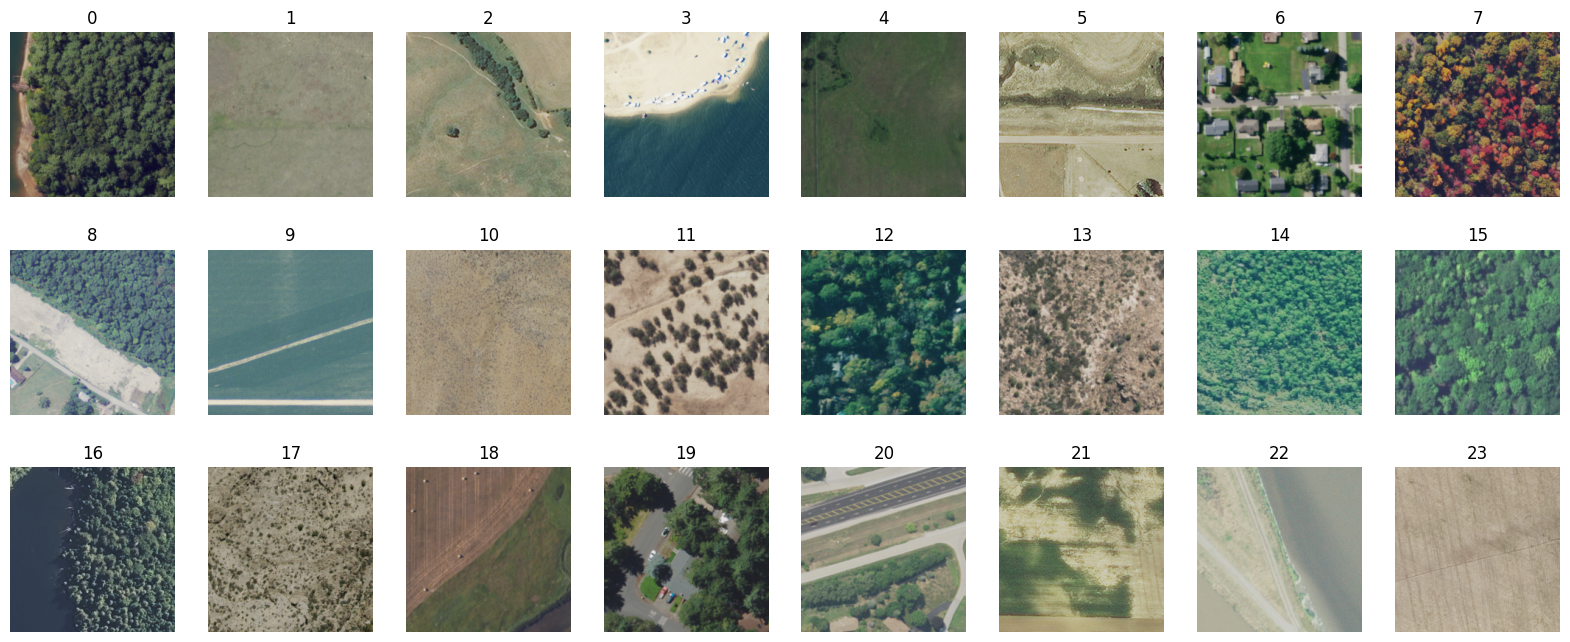

In [35]:
fig, axs = plt.subplots(3, 8, figsize=(20, 8))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(batch_naip_pixels[idx, :3,...].transpose(1,2,0))
    ax.set_axis_off()
    ax.set_title(idx)

Rearrange the embeddings from the Clay Encoder back to images.

Embeddings are of shape: `batch x (1:cls_token + 784:patches) x 768:embedding dimension`  
`784:patches` can be transformed into images of shape `28 x 28`  
`768:embedding dimension` can be moved as channel dimension  
Here, each embedding dims represents a particular unique feature of the chip

In [46]:
unmsk_embed = rearrange(unmsk_patch_naip[:,1:,:].detach().cpu().numpy(), 
                "b (h w) d-> b d h w",
                h=28,
                w=28)

Pick a NAIP chip from the first 24 plotted above and visualize what each of the embedding dims look like for it. To prevent overflowing the notebook, lets plot the first 256 embedding dimensions. 

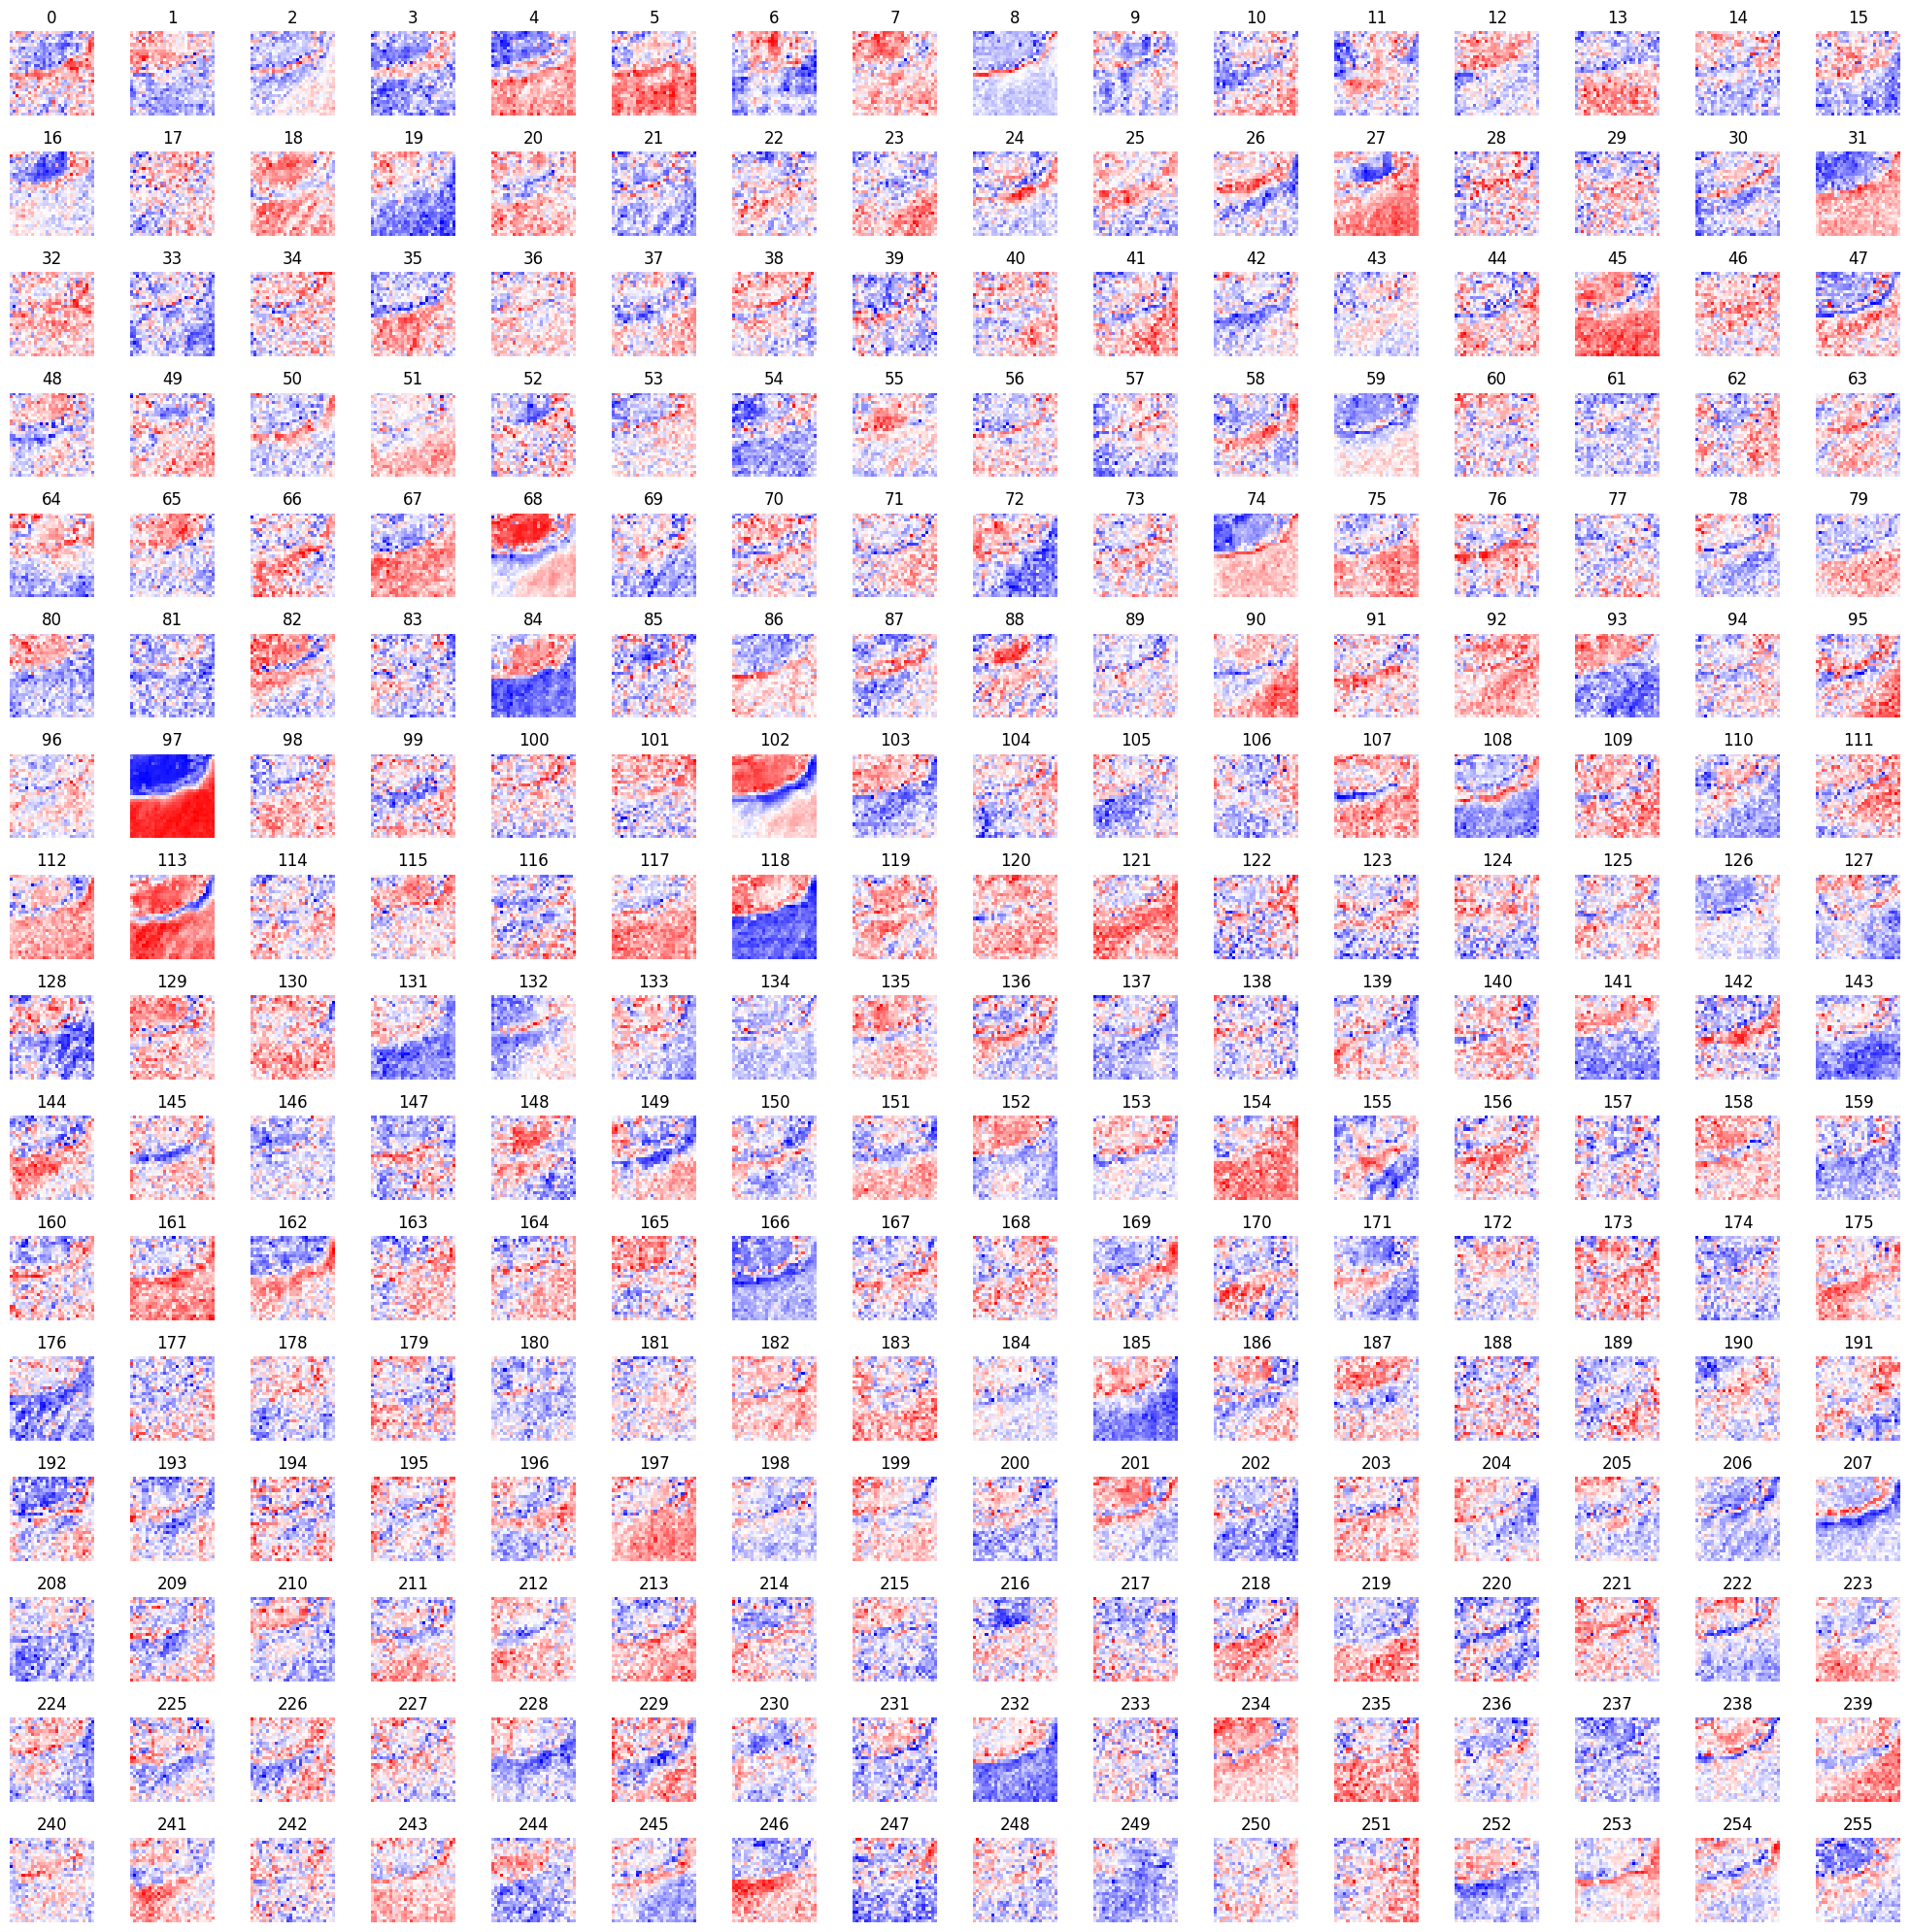

In [47]:
embed = unmsk_embed[3] # 3 is randomly picked chip
fig, axs = plt.subplots(16, 16, figsize=(20, 20))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)
plt.tight_layout()

As we see above, each embedding dimension represents a feature of the chip. Some are simple & easy to interpret for human eyes like edges, patterns, features like land & water - while some are more complex.  
Now, lets pick one embedding from the `768` plotted above & visualize the same for all the chips.

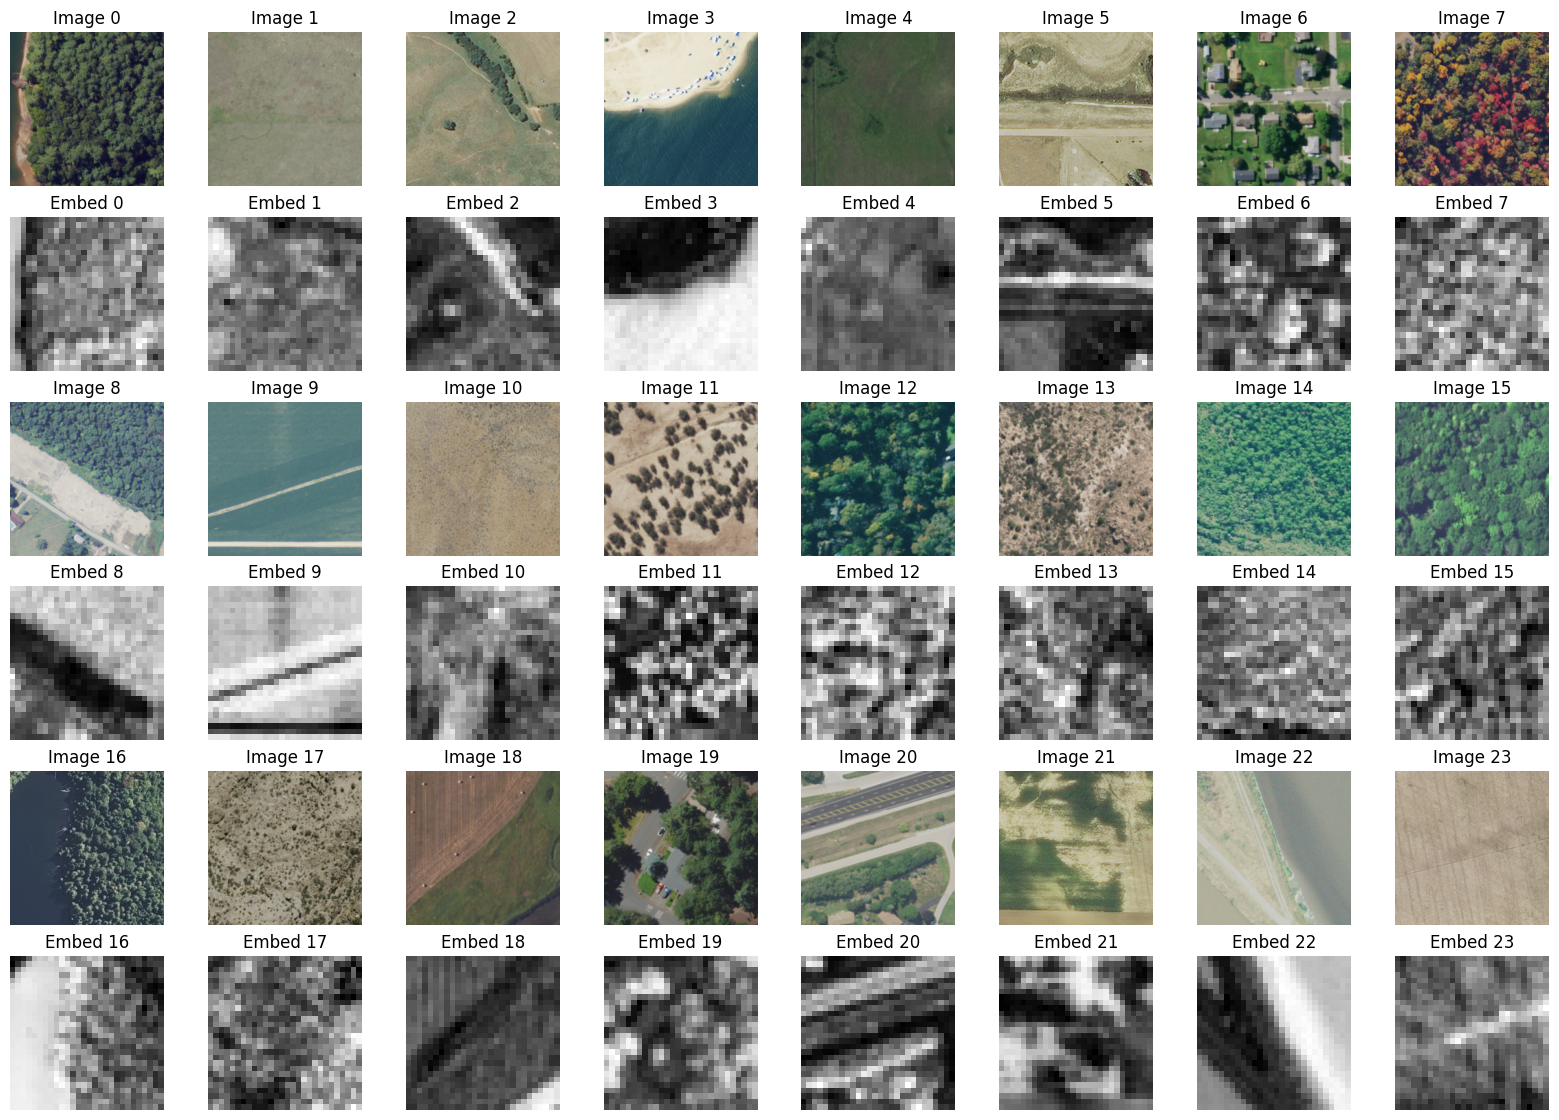

In [48]:
fig, axs = plt.subplots(6, 8, figsize=(20, 14))
embed_dim = 97 # pick any embedding dimension

for i in range(0, 6, 2):
    for j in range(8):
        idx = (i//2)*8+j
        axs[i][j].imshow(batch_naip_pixels[idx, :3,...].transpose(1,2,0))
        axs[i][j].set_axis_off()
        axs[i][j].set_title(f"Image {idx}")
        embed = unmsk_embed[idx]
        axs[i+1][j].imshow(embed[embed_dim], cmap="gray")
        axs[i+1][j].set_axis_off()
        axs[i+1][j].set_title(f"Embed {idx}")

### VISUALIZE EMBEDDINGS of S2

We will repeat the same set of steps for Sentinel 2 now.

In [39]:
s2_mean = list(dm.metadata["sentinel-2-l2a"].bands.mean.values())
s2_std = list(dm.metadata["sentinel-2-l2a"].bands.std.values())

batch_s2_pixels = batch_s2["pixels"].detach().cpu().numpy()
batch_s2_pixels = denormalize_images(batch_s2_pixels, s2_mean, s2_std)

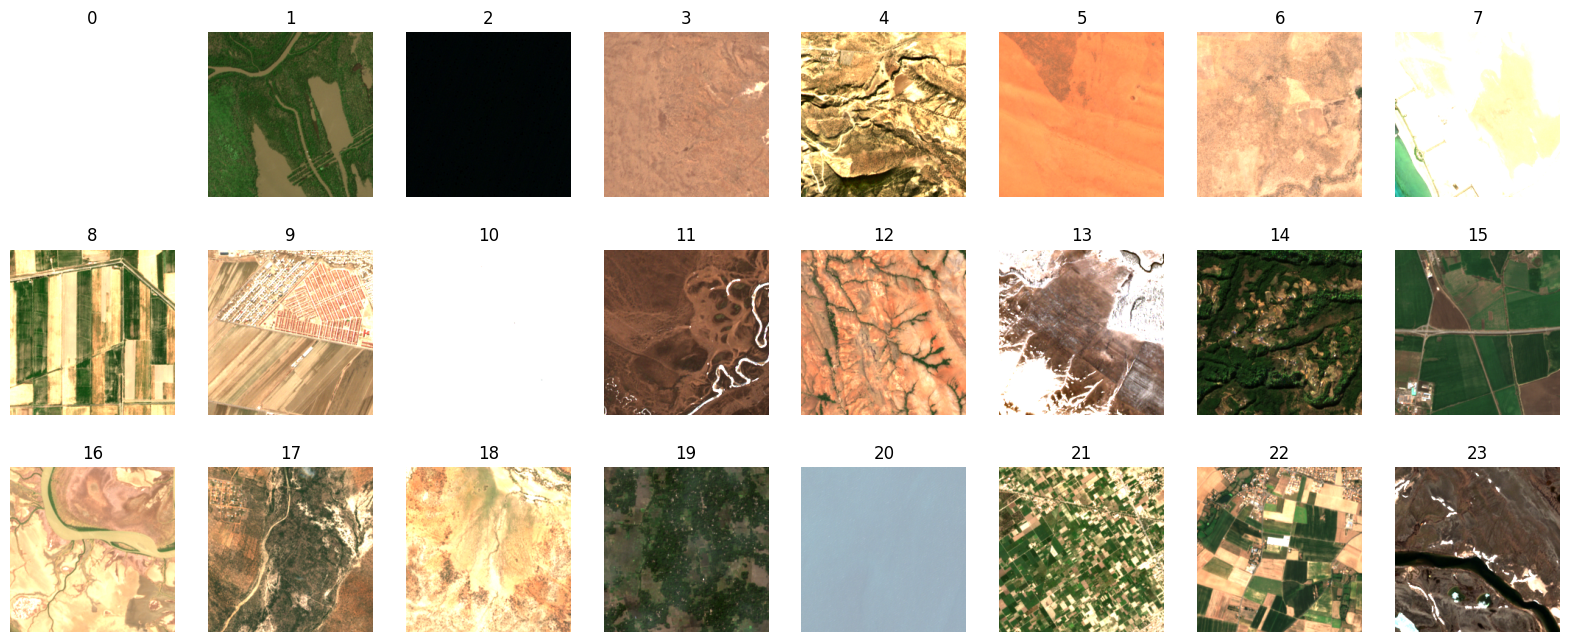

In [40]:
fig, axs = plt.subplots(3, 8, figsize=(20, 8))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(np.clip(batch_s2_pixels[idx, [2, 1, 0],...].transpose(1,2,0)/2000, 0, 1))
    ax.set_axis_off()
    ax.set_title(idx)

In [41]:
unmsk_embed_s2 = rearrange(unmsk_patch_s2[:,1:,:].detach().cpu().numpy(), 
                "b (h w) d-> b d h w",
                h=28,
                w=28)

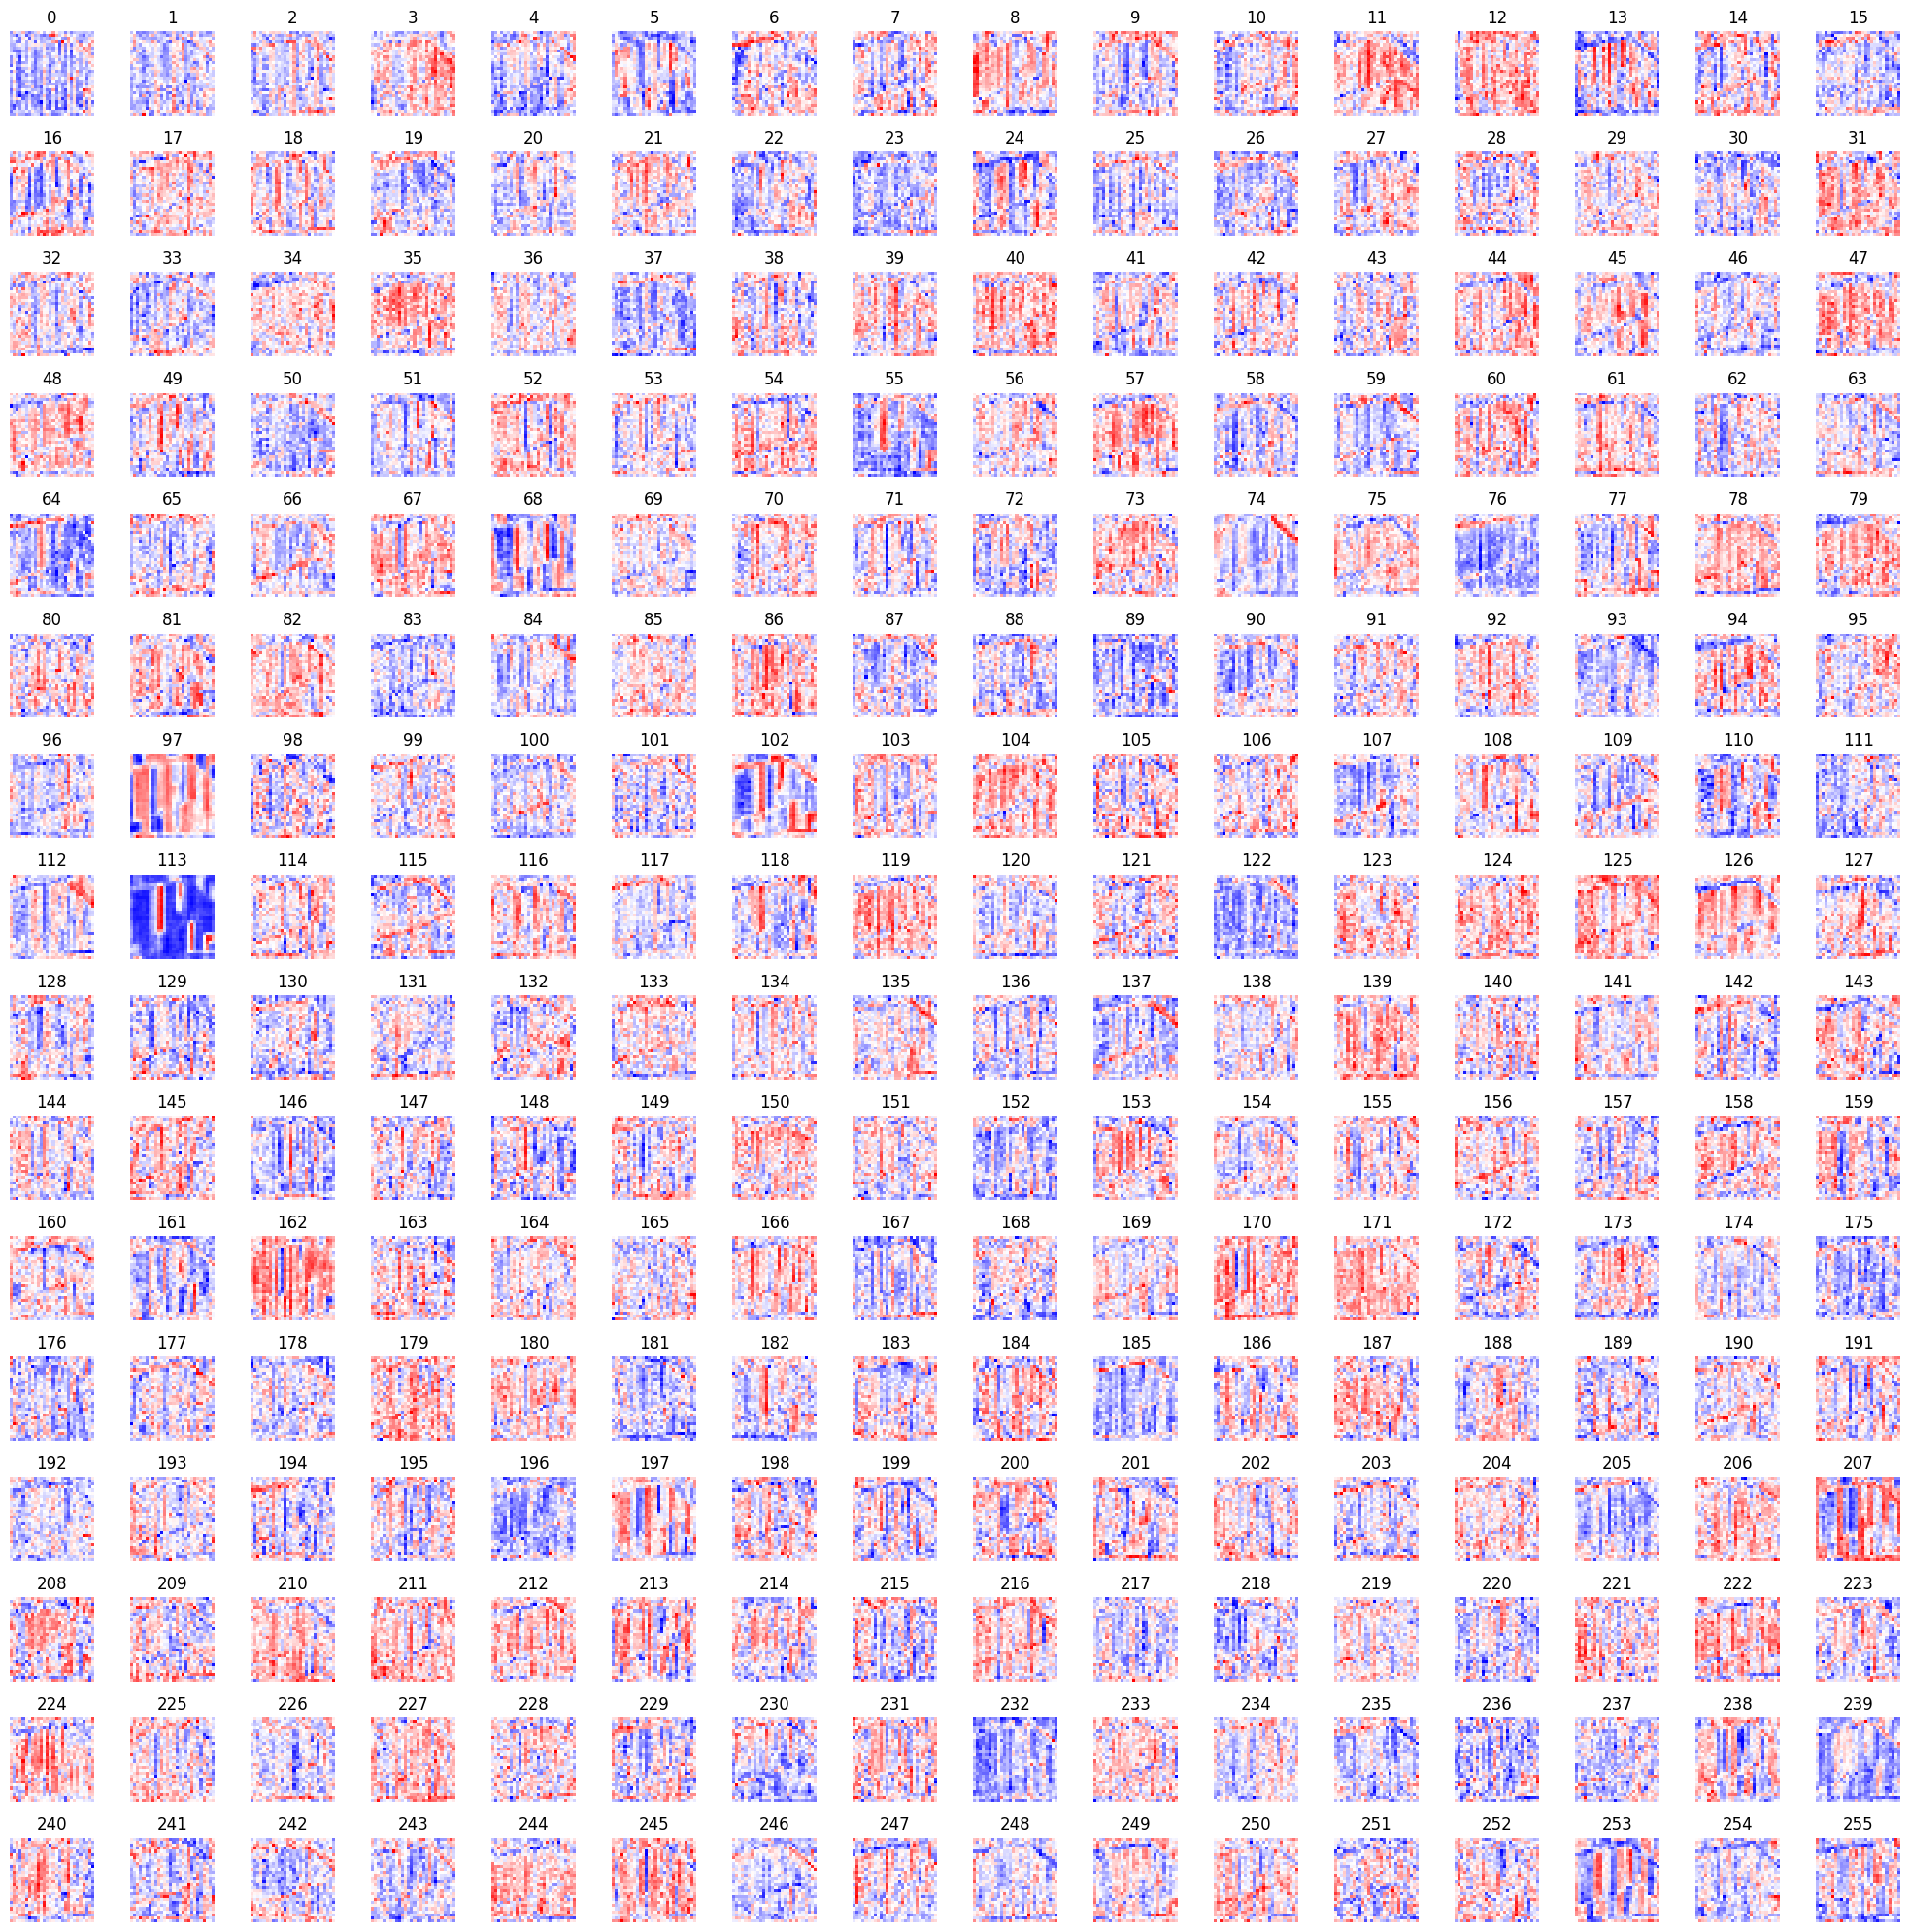

In [44]:
embed_s2 = unmsk_embed_s2[8]
fig, axs = plt.subplots(16, 16, figsize=(20, 20))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(embed_s2[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)
plt.tight_layout()

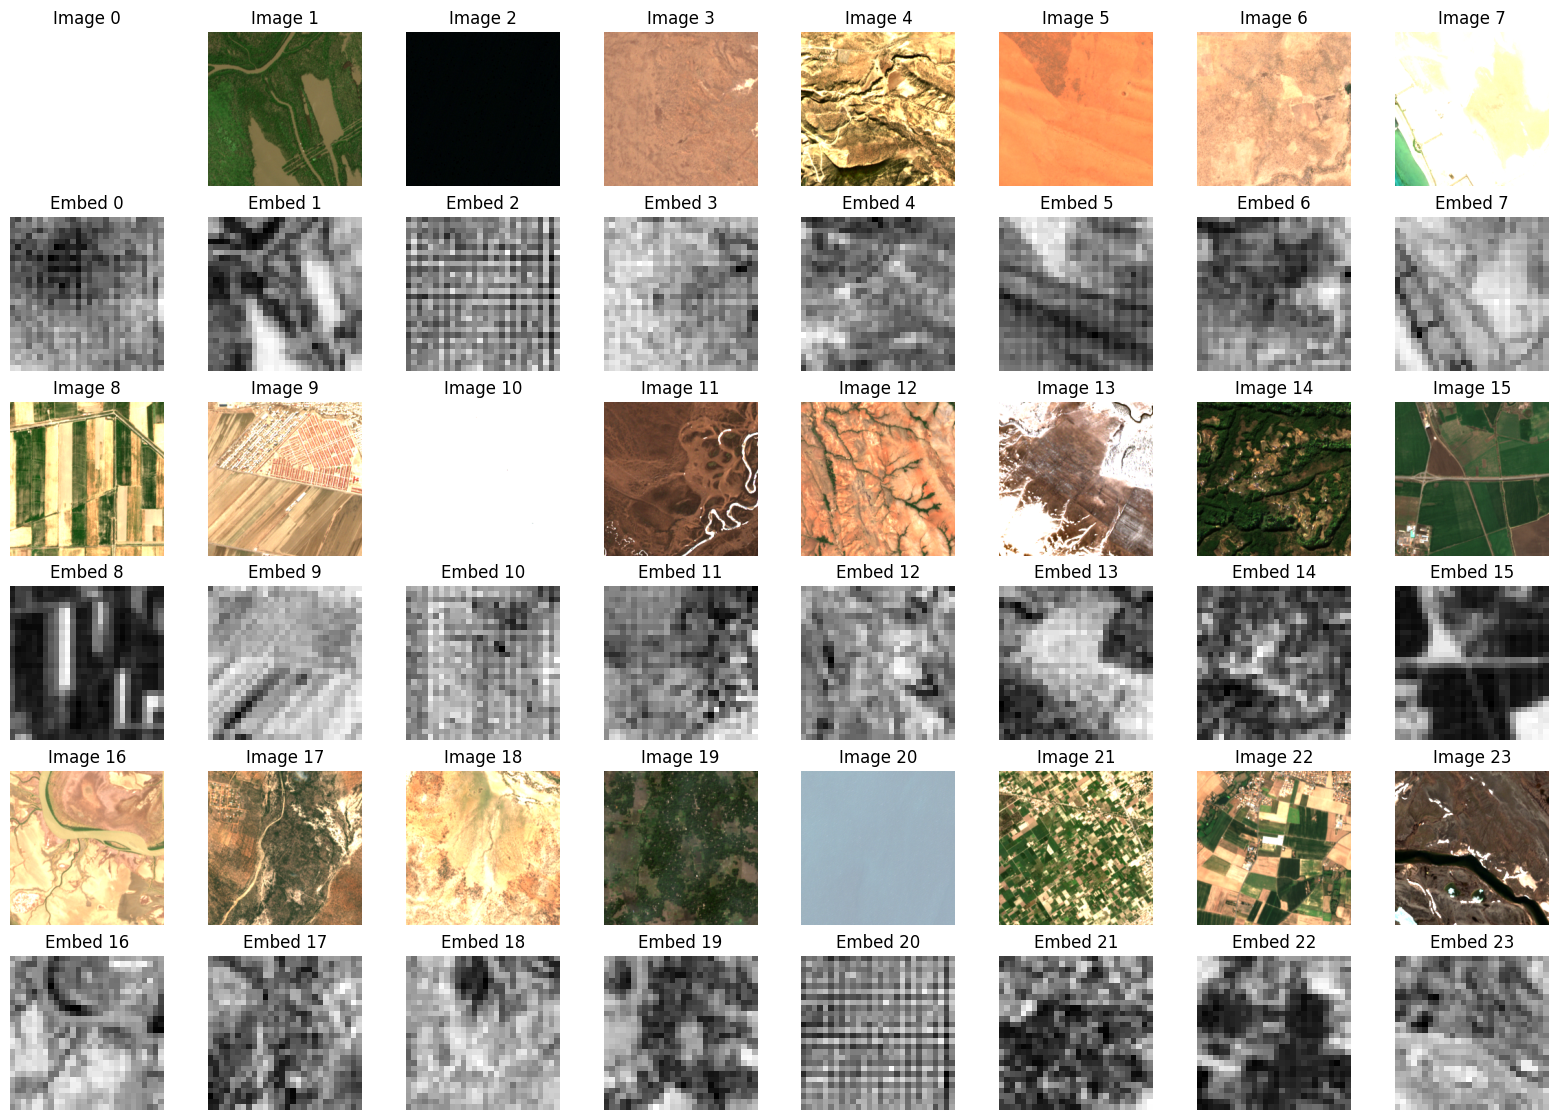

In [45]:
fig, axs = plt.subplots(6, 8, figsize=(20, 14))
embed_dim = 113

for i in range(0, 6, 2):
    for j in range(8):
        idx = (i//2)*8+j
        axs[i][j].imshow(np.clip(batch_s2_pixels[idx,[2, 1, 0],...].transpose(1,2,0)/2000, 0, 1))
        axs[i][j].set_axis_off()
        axs[i][j].set_title(f"Image {idx}")
        embed_s2 = unmsk_embed_s2[idx]
        axs[i+1][j].imshow(embed_s2[embed_dim], cmap="gray")
        axs[i+1][j].set_axis_off()
        axs[i+1][j].set_title(f"Embed {idx}")

## Next steps

- Visualize embeddings for other sensors that the model is trained on i.e Landsat, Sentinel-1, LINZ
- Visualize embeddings for sensors that the model has not seen during training. As the model has seen imagery from 0.5cm to 30m resolution, feel free to pick a sensor that falls in or around this range. We will add support for other sensors in later release.
- Pick embeddings that seem to solve your tasks & try doing segmentation or detection using classical computer vision (will be a fun exercise).